# 1 - Importacão das bibliotecas

In [36]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
#import warnings
#warning.simplefilter(action= 'ignore', category = FutureWarning)

# Entendimento dos dados

## Load the dataset

In [37]:
path = '~/repos/Projetos-Data-Science/Projeto House Rocket/dataset/kc_house_data.csv'

def data_collect(path):
    dataframe = pd.read_csv(path, parse_dates=['date'])

    return dataframe

data = data_collect(path)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [38]:
# Dimensions of the data

def show_dimensions(data):
    print(f'Quantidade de linhas do dataset {data.shape[0]}')
    print(f'Quantidade de colunas do dataset {data.shape[1]}\n')
    
    return None

def show_dtypes(data):
    # Data Types
    data.info()
    
    return None

def data_transformation(data):
    
    data['standard'] = data['price'].apply(lambda x: 'high_standard' if x >= 540000 else 'low_standard')

    data['dormitory_type'] = data['bedrooms'].apply(lambda x: 'studio' if x == 1 else
                                                              'apartment' if x == 2 else
                                                              'house')

    data['condition_type'] = data['condition'].apply(lambda x: 'very bad' if x == 1 else
                                                        'bad' if x == 2 else
                                                        'regular' if x == 3 else
                                                        'good' if x == 4 else
                                                        'very good')

    data['construction'] = data['yr_built'].apply(lambda x: '>1955' if x > 1955 else '<1955')

    data['basement_status'] = data['sqft_basement'].apply(lambda x: 'yes' if x != 0 else 'no')

    data['month'] = data['date'].apply(lambda x: int(x.strftime('%m')))

    data['season'] = data['month'].apply(lambda x: 'spring' if  (x >=3) and (x <= 5)  else
                                                   'summer' if  (x >=6) and (x <= 8)  else
                                                   'fall'   if  (x >=9) and (x <= 11) else
                                                   'winter')

    data['waterfront_status'] = data['waterfront'].apply(lambda x: 'no' if x == 0 else
                                                         'yes')

    data['renovated_status'] = data['yr_renovated'].apply(lambda x: 'yes' if x != 0 else 'no')
    
    data['year'] = pd.to_datetime(data['date']).dt.year
    
    data['year_month'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m')
    
    data['recomendation'] = None
    
    data['sell_price'] = 0
    
    data['profit'] = 0
    
    
    return data

def recomendation_buy(data):
    df = data.copy()
    df = df[['price', 'zipcode']].groupby('zipcode').median().reset_index()

    df1 = pd.merge(data, df,  on='zipcode', how='inner')

    df1.rename(columns={'price_x': 'price',
                        'price_y': 'price_median_region'}, inplace=True)

    df1['recomendation'] = df1[['price', 'price_median_region', 'condition']].apply(
    lambda x: 'comprar' if (x['price'] <= x['price_median_region']) & (x['condition'] >= 3) else
              'não comprar', axis = 1
    )
    
    data = df1
    
    return data

def recomendation_sell(data):
    df1 = data.copy()
    df1 = df1.loc[df1['recomendation'] == 'comprar', : ].copy()
    
    
    df2 = df1[['price', 'zipcode', 'season']].groupby(by=['zipcode', 'season']).median().reset_index()
    
    df_partial = pd.merge(df1, df2, how='inner', on=['zipcode', 'season'])
    
    df_partial.rename(columns={'price_x':'price',
                              'price_y':'price_median_season'}, inplace=True)
    
    df_all = df_partial.copy()
    
    df_all['sell_price'] = df_all[['price', 'price_median_season', 'price_median_region']].apply(
        lambda x: x['price'] * 1.1 if (x['price'] >= x['price_median_season']) else 
        x['price'] * 1.3 if (x['price'] <= x['price_median_season']) & 
        (x['price'] * 1.3 < x['price_median_season']) else x['price_median_season'], axis = 1 
        )
    
    df_all['profit'] = df_all[['price', 'sell_price']].apply(lambda x: x['sell_price'] - x['price'], axis = 1)
    
    return df_all

# Limpeza dos dados

In [39]:
show_dimensions(data)

Quantidade de linhas do dataset 21613
Quantidade de colunas do dataset 21



In [40]:
# Tratando dados duplicados
data['id'].nunique()

21436

In [41]:
id_counts = data['id'].value_counts()
dupe_ids = id_counts > 1
dupe_mask = id_counts.index[dupe_ids]

dupe_maks = list(dupe_mask)
data.loc[data['id'].isin(dupe_mask), : ].head(int(len(dupe_mask) * 0.1))

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-07-25,430000.00,3,1.50,1580,5000,1.00,0,0,...,8,1290,290,1939,0,98117,47.69,-122.39,1570,4500
94,6021501535,2014-12-23,700000.00,3,1.50,1580,5000,1.00,0,0,...,8,1290,290,1939,0,98117,47.69,-122.39,1570,4500
313,4139480200,2014-06-18,1384000.00,4,3.25,4290,12103,1.00,0,3,...,11,2690,1600,1997,0,98006,47.55,-122.10,3860,11244
314,4139480200,2014-12-09,1400000.00,4,3.25,4290,12103,1.00,0,3,...,11,2690,1600,1997,0,98006,47.55,-122.10,3860,11244
324,7520000520,2014-09-05,232000.00,2,1.00,1240,12092,1.00,0,0,...,6,960,280,1922,1984,98146,47.50,-122.35,1820,7460
325,7520000520,2015-03-11,240500.00,2,1.00,1240,12092,1.00,0,0,...,6,960,280,1922,1984,98146,47.50,-122.35,1820,7460
345,3969300030,2014-07-23,165000.00,4,1.00,1000,7134,1.00,0,0,...,6,1000,0,1943,0,98178,47.49,-122.24,1020,7138
346,3969300030,2014-12-29,239900.00,4,1.00,1000,7134,1.00,0,0,...,6,1000,0,1943,0,98178,47.49,-122.24,1020,7138
371,2231500030,2014-10-01,315000.00,4,2.25,2180,10754,1.00,0,0,...,7,1100,1080,1954,0,98133,47.77,-122.34,1810,6929
372,2231500030,2015-03-24,530000.00,4,2.25,2180,10754,1.00,0,0,...,7,1100,1080,1954,0,98133,47.77,-122.34,1810,6929


In [42]:
data.drop_duplicates(subset='id', keep='last', inplace=True)

In [43]:
show_dimensions(data)

Quantidade de linhas do dataset 21436
Quantidade de colunas do dataset 21



In [44]:
# Tratando os outliers e valores inconclusivos
data.describe(include= 'int64')

,id,bedrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00
mean,4580765328.18,3.37,2082.70,15135.64,0.01,0.24,3.41,7.66,1790.96,291.74,1971.10,84.73,98077.86,1988.31,12785.96
std,2876589633.67,0.93,919.15,41538.62,0.09,0.77,0.65,1.17,829.03,442.78,29.39,402.43,53.47,685.70,27375.47
min,1000102.00,0.00,290.00,520.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,399.00,651.00
25%,2123700078.75,3.00,1430.00,5040.00,0.00,0.00,3.00,7.00,1200.00,0.00,1952.00,0.00,98033.00,1490.00,5100.00
50%,3904921185.00,3.00,1920.00,7614.00,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,1840.00,7620.00
75%,7308675062.50,4.00,2550.00,10696.25,0.00,0.00,4.00,8.00,2220.00,560.00,1997.00,0.00,98117.00,2370.00,10087.25
max,9900000190.00,33.00,13540.00,1651359.00,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,6210.00,871200.00


In [45]:
data.describe(include= 'float64')

,price,bathrooms,floors,lat,long
count,21436.00,21436.00,21436.00,21436.00,21436.00
mean,541649.96,2.12,1.50,47.56,-122.21
std,367314.93,0.77,0.54,0.14,0.14
min,75000.00,0.00,1.00,47.16,-122.52
25%,324866.00,1.75,1.00,47.47,-122.33
50%,450000.00,2.25,1.50,47.57,-122.23
75%,645000.00,2.50,2.00,47.68,-122.12
max,7700000.00,8.00,3.50,47.78,-121.31


In [46]:
data.loc[(data['bedrooms'] == 3) & (data['zipcode'] == 98103), ].describe().T

,count,mean,std,min,25%,50%,75%,max
id,282.00,4442471640.39,3021489955.30,263000006.00,1972200277.25,3797002242.50,6749700023.75,9551201250.00
price,282.00,558990.60,175307.95,245000.00,415250.00,543000.00,660000.00,1555000.00
bedrooms,282.00,3.00,0.00,3.00,3.00,3.00,3.00,3.00
bathrooms,282.00,2.05,0.70,0.75,1.75,2.00,2.50,4.00
sqft_living,282.00,1612.38,402.02,800.00,1360.00,1530.00,1795.00,4360.00
sqft_lot,282.00,2969.77,1796.55,651.00,1320.75,2669.00,4164.75,9450.00
floors,282.00,2.09,0.84,1.00,1.50,2.00,3.00,3.50
waterfront,282.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
view,282.00,0.17,0.67,0.00,0.00,0.00,0.00,4.00
condition,282.00,3.40,0.72,1.00,3.00,3.00,4.00,5.00


In [47]:
data.loc[data['bedrooms'] == 33, ].describe().T

,count,mean,std,min,25%,50%,75%,max
id,1.00,2402100895.00,nan,2402100895.00,2402100895.00,2402100895.00,2402100895.00,2402100895.00
price,1.00,640000.00,nan,640000.00,640000.00,640000.00,640000.00,640000.00
bedrooms,1.00,33.00,nan,33.00,33.00,33.00,33.00,33.00
bathrooms,1.00,1.75,nan,1.75,1.75,1.75,1.75,1.75
sqft_living,1.00,1620.00,nan,1620.00,1620.00,1620.00,1620.00,1620.00
sqft_lot,1.00,6000.00,nan,6000.00,6000.00,6000.00,6000.00,6000.00
floors,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00
waterfront,1.00,0.00,nan,0.00,0.00,0.00,0.00,0.00
view,1.00,0.00,nan,0.00,0.00,0.00,0.00,0.00
condition,1.00,5.00,nan,5.00,5.00,5.00,5.00,5.00


In [48]:
data.loc[data['bedrooms'] == 33, 'bedrooms'] = 3

In [49]:
data = data.loc[data['bathrooms'] != 0 ]

# Transformação dos dados

In [50]:
data = data_transformation(data)

# Exploração dos dados
 1 - Analise Descritiva

In [51]:
data_static = data.describe().T
data_static.loc[data_static.index[1: -1 ] , ['mean', 'min', 'max', 'std', '50%']]

,mean,min,max,std,50%
price,541693.60,78000.00,7700000.00,367296.43,450000.00
bedrooms,3.37,0.00,11.00,0.90,3.00
bathrooms,2.12,0.50,8.00,0.77,2.25
sqft_living,2082.91,370.00,13540.00,918.85,1920.00
sqft_lot,15135.10,520.00,1651359.00,41547.34,7613.50
floors,1.50,1.00,3.50,0.54,1.50
waterfront,0.01,0.00,1.00,0.09,0.00
view,0.24,0.00,4.00,0.77,0.00
condition,3.41,1.00,5.00,0.65,3.00
grade,7.66,3.00,13.00,1.17,7.00


# Insights para o negocio
 - H1 Imóveis que possuem vista para água, são 30% mais caros, na média
 - H2: Imóveis com data de construção menor que 1955, são em média 50% mais baratos
 - H3: Imóveis sem porão possuem sqrt_lot, são 50% maiores do que com porão.
 - H4: O crescimento do preço dos imóveis YoY é de 10%.
 - H5: Imóveis com 3 banheiros tem um crescimento MoM de 15%.
 - H6: Imóveis com 2 andares são 15% mais caros do que aqueles com apenas 1 andar.
 - H7: A maioria dos imóveis (+50%) se tornaram disponíveis durante summer/spring.
 - H8: Imóveis disponíveis durante summer/spring são em média 20% mais caros.
 - H9: Imóveis que não foram renovados, são em média 40% mais baratos.

In [52]:
# H1 Imóveis que possuem vista para água, são 30% mais caros, na média em comparação aos que não tem vista para água
df_waterview = data[['price', 'waterfront_status']].groupby('waterfront_status').mean().reset_index()

result = round((df_waterview.loc[1, 'price'] - df_waterview.loc[0, 'price']) / df_waterview.loc[0, 'price'] * 100)

print(f'Hipotese verdadeira, imóveis com vista para a água são {result}% mais caros em comparação aos imóveis que não oferecem,vista para a água')

Hipotese verdadeira, imóveis com vista para a água são 212.0% mais caros em comparação aos imóveis que não oferecem,vista para a água


In [53]:
# H2: Imóveis com data de construção menor que 1955, são em média 50% mais baratos
df_construction = data[['construction', 'price']].groupby('construction').mean().reset_index()
result = round((df_construction.loc[1, 'price'] - df_construction.loc[0, 'price']) / df_construction.loc[0, 'price'] * 100)

print(f'Hipotese falsa, as imóveis datados acima do ano de 1955 são apenas {result}% mais caros do que imóveis com data de construção menores que 1955')

Hipotese falsa, as imóveis datados acima do ano de 1955 são apenas 1.0% mais caros do que imóveis com data de construção menores que 1955


In [54]:
# H3: Imóveis sem porão possuem sqrt_lot, são 50% maiores do que com porão.
df_basement = data[['sqft_lot', 'basement_status']].groupby('basement_status').mean().reset_index()

result_basement = round((df_basement.loc[0, 'sqft_lot'] - df_basement.loc[1, 'sqft_lot']) / df_basement.loc[0, 'sqft_lot'] * 100)

print(f'Hipotese falsa, casas sem porão, possuem cerca de apenas {result_basement}% de pés quadrados a mais em comparação a casas com porão')

Hipotese falsa, casas sem porão, possuem cerca de apenas 19.0% de pés quadrados a mais em comparação a casas com porão


In [55]:
# H4: O crescimento do preço dos imóveis entre os anos de 2014 e 2015 é de 10%.
df_yoy = data[['price', 'year']].groupby('year').mean().reset_index()

result_yoy = round((df_yoy.loc[1, 'price'] - df_yoy.loc[0, 'price']) / df_yoy.loc[0, 'price'] * 100, 2)
print(f'Hipotese Falsa, o crescimento médio entre os anos de 2014 e 2015 foi de {result_yoy}%.')

Hipotese Falsa, o crescimento médio entre os anos de 2014 e 2015 foi de 0.22%.


Hipotese Falsa, imóveis com 3 banheiros tem um crescimento em média MoM de apenas 0.18%.


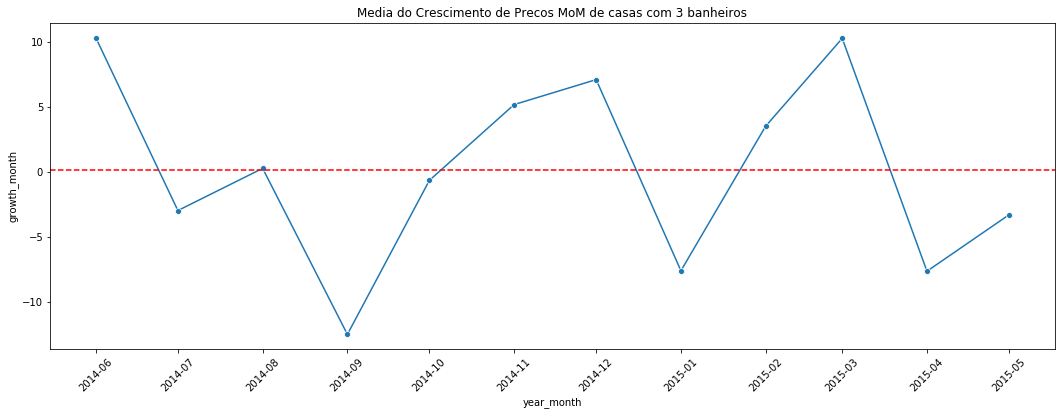

In [56]:
# H5: Imóveis com 3 banheiros tem um crescimento MoM de 15%.
df_bathrooms = data.loc[data['bathrooms'] == 3, ]

df_bathrooms = df_bathrooms[['price', 'year_month']].groupby('year_month').mean().reset_index()
df_bathrooms['year_month'] = pd.to_datetime(df_bathrooms['year_month'], format = '%Y-%m')
df_bathrooms['growth_month'] = df_bathrooms['price'].pct_change() * 100

result_bathrooms = round(df_bathrooms['growth_month'].mean(), 2)
print(f'Hipotese Falsa, imóveis com 3 banheiros tem um crescimento em média MoM de apenas {result_bathrooms}%.')

plt.figure(figsize=(18,6))
g = sns.lineplot(data = df_bathrooms, x = df_bathrooms['year_month'], y = df_bathrooms['growth_month'], marker='o');
loc = matplotlib.dates.MonthLocator()
g.xaxis.set_major_locator(loc)
g.axhline(result_bathrooms, ls='--', c='red')
plt.title('Media do Crescimento de Precos MoM de casas com 3 banheiros')
plt.xticks(rotation=45)
plt.show(g);

In [57]:
# H6: Imóveis com 2 andares são 15% mais caros do que aqueles com apenas 1 andar.
df_floors = data.loc[(data['floors']  >= 1) & (data['floors'] <= 2 ), ]

df_floors = df_floors[['price', 'floors']].groupby('floors').mean().reset_index()

result_floors = round((df_floors.loc[1, 'price'] - df_floors.loc[0, 'price']) 
                        / df_floors.loc[0, 'price'] * 100, 2)

print(f'Hipotese Verdadeira, imóveis com 2 andares são cerca de {result_floors}% mais caros em comparação \
com imóveis de apenas 1 andar.')

Hipotese Verdadeira, imóveis com 2 andares são cerca de 26.58% mais caros em comparação com imóveis de apenas 1 andar.


In [58]:
# H7: A maioria dos imóveis (+50%) se tornaram disponíveis durante summer/spring.
df_summer = data.groupby('season')['id'].count()
able_in_ss = df_summer.loc[df_summer.index.isin(['spring', 'summer']),].sum()

print(f'Hipotese verdadeira, cerca de {round((able_in_ss  / data.shape[0]) * 100, 2)}% dos imóveis \
se tornaram disponíveis na época de summer/spring.')

Hipotese verdadeira, cerca de 59.5% dos imóveis se tornaram disponíveis na época de summer/spring.


In [59]:
# H8: Imóveis disponíveis durante summer/spring são em média 20% mais caros.
df_ss = data[['season', 'price']].groupby('season').mean().reset_index()

values_ss = []
values_rest = []

for x in df_ss.iterrows():
    if (x[1][0] == 'summer') | (x[1][0] == 'spring'):
        values_ss.append(x[1][1])
    else:
        values_rest.append(x[1][1])

result_ss = round ( ( (sum(values_ss) - sum(values_rest) ) / sum(values_rest) * 100 ) ) 

print(f'Hipotese falsa, imóveis disponíveis em summer/spring são em média {result_ss:.2f}% mais caros do que imóveis \
disponíveis em outras épocas do ano.')

Hipotese falsa, imóveis disponíveis em summer/spring são em média 5.00% mais caros do que imóveis disponíveis em outras épocas do ano.


In [60]:
# H9: Imóveis que foram renovados, são em média 40% mais caros.
df_renovated = data[['price', 'renovated_status']].groupby('renovated_status').mean().reset_index()

result_renovated = (df_renovated.loc[1, 'price'] - df_renovated.loc[0, 'price']) / df_renovated.loc[0, 'price'] * 100
result_renovated

print(f'Hipotese verdadeira, imóveis que foram renovados, são em média {result_renovated:.2f}% mais caros do que imóveis \
que não foram renovados.')

Hipotese verdadeira, imóveis que foram renovados, são em média 43.28% mais caros do que imóveis que não foram renovados.


# Questões do negócio
 1. Quais são os imóveis que a House Rocket deveria comprar e por qual preço?
 2. Uma vez a casa comprada, qual o melhor momento para vendê-las e por qual preço?

In [70]:
data = data_collect(path)

In [71]:
data = data_transformation(data)

In [73]:
# 1. Quais são os imóveis que a House Rocket deveria comprar e por qual preço?
data = recomendation_buy(data)

ValueError: ('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().', 'occurred at index 0')

In [62]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,month,season,waterfront_status,renovated_status,year,year_month,recomendation,sell_price,profit,price_median_region
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,...,10,fall,no,no,2014,2014-10,comprar,0,0,279500.00
1,4060000240,2014-06-23,205425.00,2,1.00,880,6780,1.00,0,0,...,6,summer,no,no,2014,2014-06,comprar,0,0,279500.00
2,4058801670,2014-07-17,445000.00,3,2.25,2100,8201,1.00,0,2,...,7,summer,no,no,2014,2014-07,não comprar,0,0,279500.00
3,2976800796,2014-09-25,236000.00,3,1.00,1300,5898,1.00,0,0,...,9,fall,no,no,2014,2014-09,comprar,0,0,279500.00
4,6874200960,2015-02-27,170000.00,2,1.00,860,5265,1.00,0,0,...,2,winter,no,no,2015,2015-02,comprar,0,0,279500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21421,2525049086,2014-10-03,2720000.00,4,3.25,3990,18115,2.00,0,0,...,10,fall,no,no,2014,2014-10,não comprar,0,0,1905000.00
21422,2525049113,2014-07-25,1950000.00,4,3.50,4065,18713,2.00,0,0,...,7,summer,no,no,2014,2014-07,não comprar,0,0,1905000.00
21423,3262300485,2015-04-21,2250000.00,5,5.25,3410,8118,2.00,0,0,...,4,spring,no,no,2015,2015-04,não comprar,0,0,1905000.00
21424,6447300365,2014-11-13,2900000.00,5,4.00,5190,14600,2.00,0,1,...,11,fall,no,no,2014,2014-11,não comprar,0,0,1905000.00


In [67]:
def recomendation_sell(data):
    df1 = data.copy()
    df1 = df1.loc[df1['recomendation'] == 'comprar', : ].copy()
    
    df2 = df1[['price', 'zipcode', 'season']].groupby(by=['zipcode', 'season']).median().reset_index()
    
    df_partial = pd.merge(df1, df2, how='inner', on=['zipcode', 'season'])
    
    df_partial.rename(columns={'price_x':'price',
                              'price_y':'price_median_season'}, inplace=True)
    
    df_all = df_partial.copy()
    
    df_all['sell_price'] = df_all[['price', 'price_median_season',]].apply(
        lambda x: x['price'] * 1.1 if (x['price'] >= x['price_median_season']) else 
        x['price'] * 1.3 if (x['price'] <= x['price_median_season']) & 
        (x['price'] * 1.3 < x['price_median_season']) else x['price_median_season'], axis = 1 
        )
    
    df_all['profit'] = df_all[['price', 'sell_price']].apply(lambda x: x['sell_price'] - x['price'], axis = 1)
    
    return df_all 

In [68]:
# 2. Uma vez a casa comprada, qual o melhor momento para vendê-las e por qual preço?
data = recomendation_sell(data)

ValueError: ('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().', 'occurred at index 0')

In [65]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,season,waterfront_status,renovated_status,year,year_month,recomendation,sell_price,profit,price_median_region,price_median_season
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,...,fall,no,no,2014,2014-10,comprar,244090.00,22190.00,279500.00,216500.00
1,2976800796,2014-09-25,236000.00,3,1.00,1300,5898,1.00,0,0,...,fall,no,no,2014,2014-09,comprar,259600.00,23600.00,279500.00,216500.00
2,1180003090,2014-09-06,190000.00,2,1.00,630,6000,1.00,0,0,...,fall,no,yes,2014,2014-09,comprar,216500.00,26500.00,279500.00,216500.00
3,179000350,2014-11-05,194000.00,3,1.50,1010,5000,1.00,0,0,...,fall,no,no,2014,2014-11,comprar,216500.00,22500.00,279500.00,216500.00
4,3810000202,2014-09-05,251700.00,3,2.25,1810,11800,1.00,0,0,...,fall,no,no,2014,2014-09,comprar,276870.00,25170.00,279500.00,216500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10635,5425700150,2014-08-04,787500.00,4,1.75,1580,9382,1.00,0,0,...,summer,no,no,2014,2014-08,comprar,1023750.00,236250.00,1905000.00,1335000.00
10636,2525049266,2014-08-21,1762000.00,3,2.25,3060,16000,2.00,0,0,...,summer,no,no,2014,2014-08,comprar,1938200.00,176200.00,1905000.00,1335000.00
10637,5427110040,2014-06-09,1225000.00,4,2.50,2740,16007,2.00,0,0,...,summer,no,no,2014,2014-06,comprar,1335000.00,110000.00,1905000.00,1335000.00
10638,3625049079,2014-08-01,1350000.00,3,2.00,2070,9600,1.00,0,1,...,summer,no,no,2014,2014-08,comprar,1485000.00,135000.00,1905000.00,1335000.00


# Resultados financeiros para o negócio

# Conclusão

# Próximo Passo